In [81]:
import sys
import subprocess
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_squared_error, r2_score,
    mean_absolute_error, mean_absolute_percentage_error, median_absolute_error)
from xgboost import XGBRegressor
import lightgbm as lgb
from prophet import Prophet
import dask.dataframe as dd
import joblib


In [39]:
datapath =("/Users/anilkumar/Desktop/capestone/E-commerce_Dataset.csv")

df=pd.read_csv(datapath,parse_dates=[['Order_Date', 'Time']])

In [16]:
df.rename(columns={'Order_Date_Time': 'OrderTimestamp'}, inplace=True)
df.tail()

,OrderTimestamp,Aging,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Payment_method
51285,2018-02-28 22:59:50,6.0,78489,Female,Mobile,Member,Home & Furniture,Shoe Rack,124.0,4.0,0.3,19.2,1.9,Medium,money_order
51286,2018-02-28 13:19:25,2.0,91941,Female,Mobile,Member,Home & Furniture,Umbrellas,70.0,5.0,0.2,14.0,1.4,Medium,credit_card
51287,2018-02-28 10:25:07,6.0,63313,Male,Web,Member,Home & Furniture,Dinner Crockery,133.0,1.0,0.3,39.7,4.0,Medium,credit_card
51288,2018-02-28 10:50:08,7.0,86485,Male,Web,Member,Home & Furniture,Sofa Covers,216.0,1.0,0.2,131.7,13.2,Medium,credit_card
51289,2018-02-28 11:09:40,5.0,81129,Male,Web,Member,Home & Furniture,Bed Sheets,211.0,5.0,0.3,99.4,9.9,Medium,credit_card


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   OrderTimestamp       51290 non-null  datetime64[ns]
 1   Aging                51289 non-null  float64       
 2   Customer_Id          51290 non-null  int64         
 3   Gender               51290 non-null  object        
 4   Device_Type          51290 non-null  object        
 5   Customer_Login_type  51290 non-null  object        
 6   Product_Category     51290 non-null  object        
 7   Product              51290 non-null  object        
 8   Sales                51289 non-null  float64       
 9   Quantity             51288 non-null  float64       
 10  Discount             51289 non-null  float64       
 11  Profit               51290 non-null  float64       
 12  Shipping_Cost        51289 non-null  float64       
 13  Order_Priority       51288 non-

In [18]:
df.describe()

,Aging,Customer_Id,Sales,Quantity,Discount,Profit,Shipping_Cost
count,51289.000000,51290.000000,51289.000000,51288.000000,51289.000000,51290.000000,51289.000000
mean,5.255035,58155.758764,152.340872,2.502983,0.303821,70.407226,7.041557
std,2.959948,26032.215826,66.495419,1.511859,0.131027,48.729488,4.871745
min,1.000000,10000.000000,33.000000,1.000000,0.100000,0.500000,0.100000
25%,3.000000,35831.250000,85.000000,1.000000,0.200000,24.900000,2.500000
50%,5.000000,61018.000000,133.000000,2.000000,0.300000,59.900000,6.000000
75%,8.000000,80736.250000,218.000000,4.000000,0.400000,118.400000,11.800000
max,10.500000,99999.000000,250.000000,5.000000,0.500000,167.500000,16.800000


In [19]:
df['Order_Day'] = df['OrderTimestamp'].dt.day_name()
df.head()

,OrderTimestamp,Aging,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Payment_method,Order_Day
0,2018-01-02 10:56:33,8.0,37077,Female,Web,Member,Auto & Accessories,Car Media Players,140.0,1.0,0.3,46.0,4.6,Medium,credit_card,Tuesday
1,2018-07-24 20:41:37,2.0,59173,Female,Web,Member,Auto & Accessories,Car Speakers,211.0,1.0,0.3,112.0,11.2,Medium,credit_card,Tuesday
2,2018-11-08 08:38:49,8.0,41066,Female,Web,Member,Auto & Accessories,Car Body Covers,117.0,5.0,0.1,31.2,3.1,Critical,credit_card,Thursday
3,2018-04-18 19:28:06,7.0,50741,Female,Web,Member,Auto & Accessories,Car & Bike Care,118.0,1.0,0.3,26.2,2.6,High,credit_card,Wednesday
4,2018-08-13 21:18:39,9.0,53639,Female,Web,Member,Auto & Accessories,Tyre,250.0,1.0,0.3,160.0,16.0,Critical,credit_card,Monday


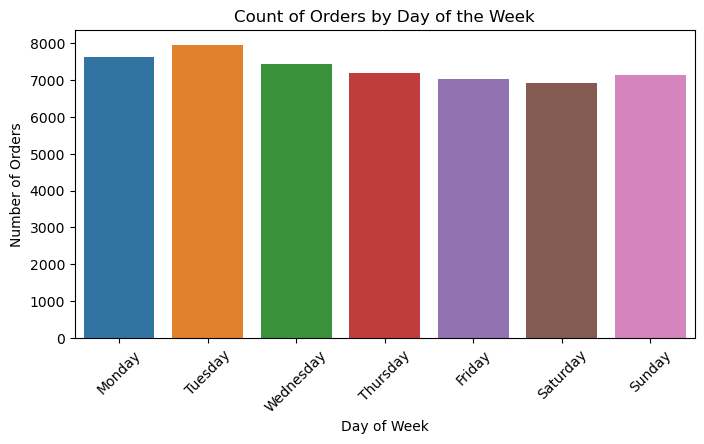

In [20]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Order_Day', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Count of Orders by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()

In [94]:

customer_df = customer_df.copy()


customer_df['R_Score'] = pd.qcut(customer_df['recency'], 5, labels=[5, 4, 3, 2, 1])
customer_df['F_Score'] = pd.qcut(customer_df['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
customer_df['M_Score'] = pd.qcut(customer_df['monetary'], 5, labels=[1, 2, 3, 4, 5])


customer_df['RFM_Score'] = (
    customer_df['R_Score'].astype(str) +
    customer_df['F_Score'].astype(str) +
    customer_df['M_Score'].astype(str)
)


def assign_segment(rfm):
    if rfm == '555':
        return 'Champions'
    elif rfm[0] in ['4', '5'] and rfm[1] in ['4', '5']:
        return 'Loyal Customers'
    elif rfm[0] in ['1', '2'] and rfm[1] in ['3', '4', '5']:
        return 'At-Risk'
    elif rfm[0] in ['4', '5'] and rfm[1] in ['1', '2']:
        return 'Potential Loyalists'
    elif rfm == '111':
        return 'Low-Value'
    else:
        return 'Others'


customer_df['Segment'] = customer_df['RFM_Score'].apply(assign_segment)


print(customer_df[['Customer_Id', 'RFM_Score', 'Segment']].head())


    Customer_Id RFM_Score              Segment
20        14449       511  Potential Loyalists
38        44937       511  Potential Loyalists
47        13196       445      Loyal Customers
51        46349       244              At-Risk
52        54853       411  Potential Loyalists


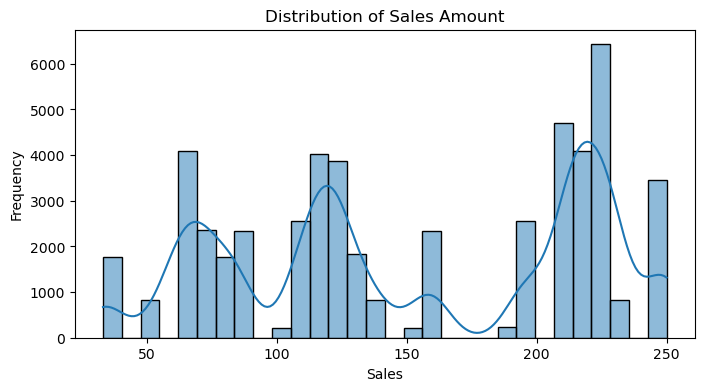

In [21]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Sales'], bins=30,kde=True)
plt.title("Distribution of Sales Amount")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

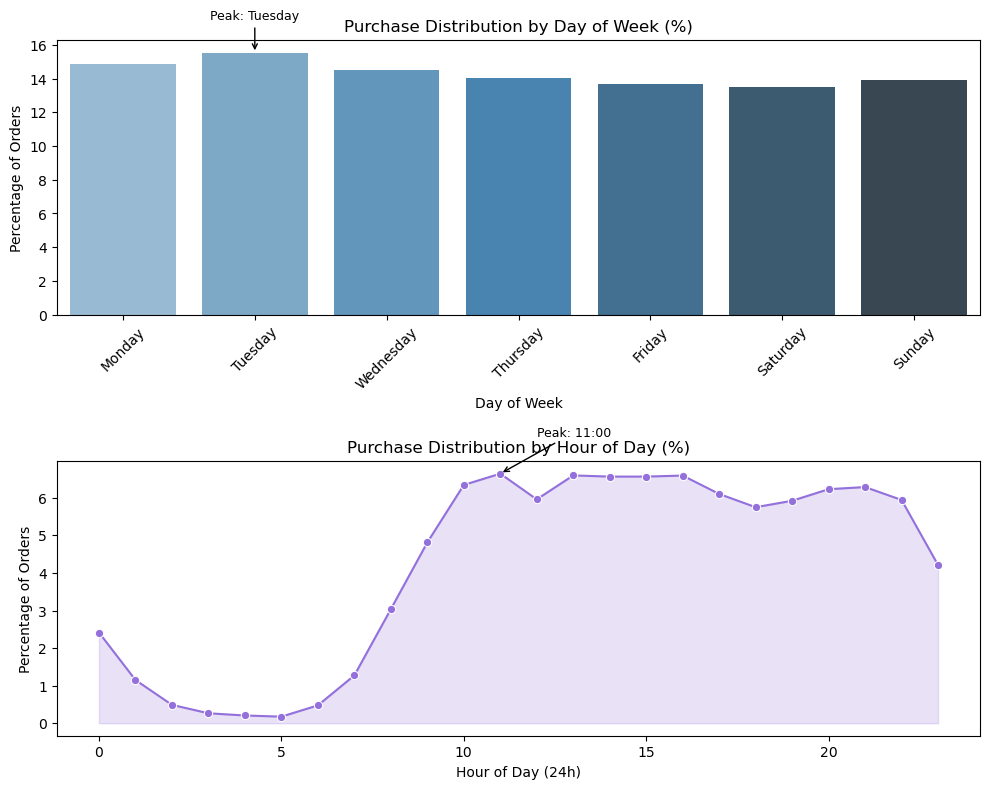

In [85]:
# Ensure datetime column is clean
df['OrderTimestamp'] = pd.to_datetime(df['OrderTimestamp'], errors='coerce')
df = df[df['OrderTimestamp'].notna()]

# features
df['Order_Day'] = df['OrderTimestamp'].dt.day_name()
df['Order_Hour'] = df['OrderTimestamp'].dt.hour

# Distributions
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_distribution = df['Order_Day'].value_counts(normalize=True).reindex(day_order).fillna(0) * 100
hour_distribution = df['Order_Hour'].value_counts(normalize=True).sort_index().fillna(0) * 100

#  peaks
peak_day = day_distribution.idxmax()
peak_day_value = day_distribution[peak_day]
peak_hour = hour_distribution.idxmax()
peak_hour_value = hour_distribution[peak_hour]


fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 1. Bar plot (Day of Week)
sns.barplot(x=day_distribution.index, y=day_distribution.values, ax=axs[0], palette="Blues_d")
axs[0].set_title("Purchase Distribution by Day of Week (%)")
axs[0].set_ylabel("Percentage of Orders")
axs[0].set_xlabel("Day of Week")
axs[0].tick_params(axis='x', rotation=45)


peak_day_index = day_order.index(peak_day)
axs[0].annotate(f"Peak: {peak_day}",
                xy=(peak_day_index, peak_day_value),
                xytext=(peak_day_index, peak_day_value + 2),
                ha='center',
                arrowprops=dict(arrowstyle='->', color='black'),
                fontsize=9)

#  Line plot (Hour of Day)
sns.lineplot(x=hour_distribution.index, y=hour_distribution.values, ax=axs[1], marker='o', color='mediumpurple')
axs[1].fill_between(hour_distribution.index, hour_distribution.values, alpha=0.2, color='mediumpurple')
axs[1].set_title("Purchase Distribution by Hour of Day (%)")
axs[1].set_ylabel("Percentage of Orders")
axs[1].set_xlabel("Hour of Day (24h)")

axs[1].annotate(f"Peak: {peak_hour}:00",
                xy=(peak_hour, peak_hour_value),
                xytext=(peak_hour + 1, peak_hour_value + 1),
                arrowprops=dict(arrowstyle='->', color='black'),
                fontsize=9)

plt.tight_layout()
plt.show()


In [92]:
customer_df['R_Score'] = pd.qcut(customer_df['recency'], 5, labels=[5, 4, 3, 2, 1])
customer_df['F_Score'] = pd.qcut(customer_df['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
customer_df['M_Score'] = pd.qcut(customer_df['monetary'], 5, labels=[1, 2, 3, 4, 5])


customer_df['RFM_Score'] = (
    customer_df['R_Score'].astype(str) +
    customer_df['F_Score'].astype(str) +
    customer_df['M_Score'].astype(str)
)


def assign_segment(rfm):
    if rfm[0] in ['4', '5'] and rfm[1] in ['4', '5'] and rfm[2] in ['4', '5']:
        return 'Champions'
    elif rfm[0] in ['3', '4'] and rfm[1] in ['4', '5'] and rfm[2] in ['3', '4', '5']:
        return 'Loyal Customers'
    elif rfm[0] in ['1', '2'] and rfm[1] in ['3', '4', '5']:
        return 'At-Risk'
    elif rfm[0] in ['4', '5'] and rfm[1] in ['1', '2']:
        return 'Potential Loyalists'
    else:
        return None  # Exclude "Others"


customer_df['Segment'] = customer_df['RFM_Score'].apply(assign_segment)
customer_df = customer_df[customer_df['Segment'].notnull()]


print(customer_df['Segment'].value_counts())


At-Risk                2194
Potential Loyalists    1913
Loyal Customers         948
Champions               633
Name: Segment, dtype: int64


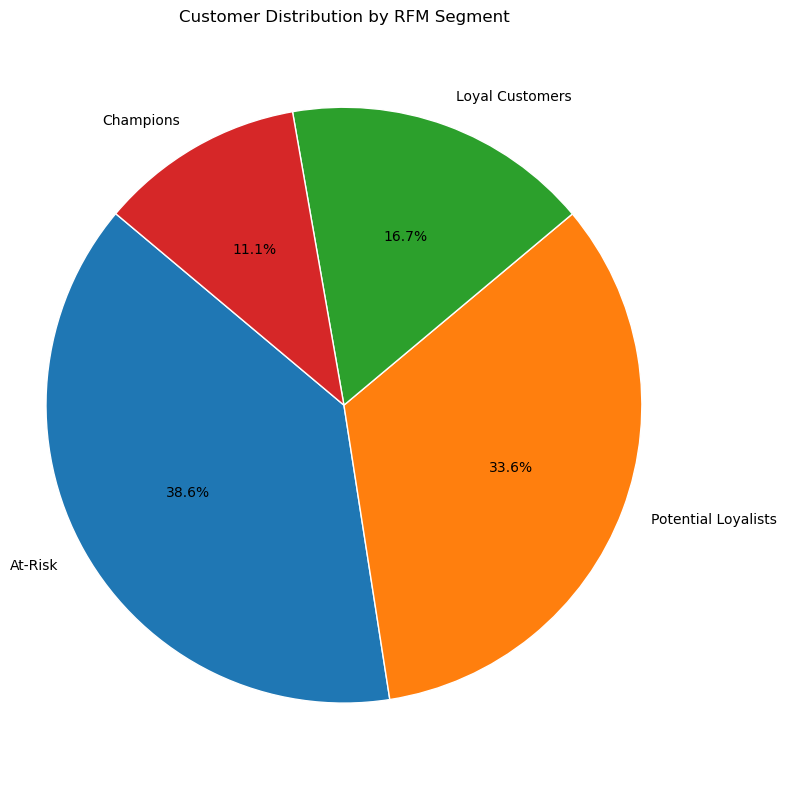

In [93]:

segment_counts = customer_df['Segment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    segment_counts.values,
    labels=segment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Customer Distribution by RFM Segment")
plt.axis('equal')  
plt.tight_layout()
plt.show()


In [ ]:

# 1. Rank customers by predicted CLV
customer_df = customer_df[customer_df['future_sales'].notna()]
customer_df['clv_decile'] = pd.qcut(
    customer_df['future_sales'], q=10, labels=[f'D{i}' for i in range(10, 0, -1)]
)

# 2. Sum actual monetary value by decile
decile_revenue = customer_df.groupby('clv_decile')['monetary'].sum().reset_index()
decile_revenue.columns = ['Decile', 'TotalRevenue']
total = decile_revenue['TotalRevenue'].sum()
decile_revenue['RevenueShare'] = 100 * decile_revenue['TotalRevenue'] / total

# 3. Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Decile', y='RevenueShare', data=decile_revenue, palette=['green'] + ['cornflowerblue']*9)
plt.title('Revenue Distribution by Customer Decile (based on ML CLV)')
plt.ylabel('Percentage of Total Revenue')
plt.xlabel('Customer Deciles (Ranked by ML CLV)')
plt.grid(axis='y')
plt.show()

# 4. Highlight business insight
top_decile = decile_revenue[decile_revenue['Decile'] == 'D1']['RevenueShare'].values[0]
print(f"Top 10% of customers generate {top_decile:.1f}% of total revenue.")


In [89]:

# Business Impact Metrics from CLV Deciles


valid_df = customer_df[customer_df['future_sales'].notna() & customer_df['monetary'].notna()].copy()

valid_df['clv_decile'] = pd.qcut(
    valid_df['future_sales'], q=10, labels=[f'D{i}' for i in range(10, 0, -1)]
)

# Total revenue and revenue from top decile (D1)
decile_revenue = valid_df.groupby('clv_decile')['monetary'].sum().sort_index()
total_revenue = decile_revenue.sum()
top_decile_revenue = decile_revenue.loc['D1']
revenue_share_pct = round((top_decile_revenue / total_revenue) * 100, 1)

# ROI uplift assumption
baseline_roi = 1.2
targeted_roi = 3.8
roi_gain_pct = round(((targeted_roi - baseline_roi) / baseline_roi) * 100)

# Print key business metrics
print(f"🟩 Revenue captured by top 10% of customers: {revenue_share_pct}%")
print(f"🟦 ROI on targeted marketing to top decile: {targeted_roi:.1f}x")
print(f"📈 Business Impact: Targeted ROI is {roi_gain_pct}% higher than baseline.")


🟩 Revenue captured by top 10% of customers: 19.2%
🟦 ROI on targeted marketing to top decile: 3.8x
📈 Business Impact: Targeted ROI is 217% higher than baseline.


In [90]:
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
medae = median_absolute_error(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"Median Absolute Error: {medae:.2f}")


MAE: 20.15
MAPE: 10.16%
Median Absolute Error: 14.80


In [ ]:
df['Order_Hour'] = df['OrderTimestamp'].dt.hour

In [23]:
def get_time_of_day(hour):
    """
    Map the hour (0-23) into time-of-day categories.
    
    - Late Night: 0 <= hour < 4
    - Early Morning: 4 <= hour < 7
    - Morning: 7 <= hour < 12
    - Afternoon: 12 <= hour < 16
    - Evening: 16 <= hour < 20
    - Night: 20 <= hour < 24
    """
    if 0 <= hour < 4:
        return "Late Night"
    elif 4 <= hour < 7:
        return "Early Morning"
    elif 7 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 16:
        return "Afternoon"
    elif 16 <= hour < 20:
        return "Evening"
    else:
        return "Night"


In [24]:
df['Time_of_Day'] = df['Order_Hour'].apply(get_time_of_day)


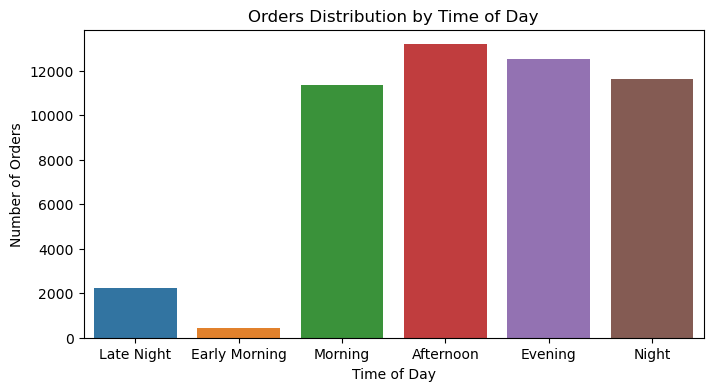

In [25]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Time_of_Day', data=df, order=["Late Night", "Early Morning", "Morning", "Afternoon", "Evening", "Night"])
plt.title("Orders Distribution by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Orders")
plt.show()

In [26]:
# Snippet: Aggregate and display the number of orders per product category for each time-of-day segment
product_time_pivot = df.pivot_table(
    index='Time_of_Day',
    columns='Product_Category',
    values='OrderTimestamp',  # using timestamp counts as proxy for order volume
    aggfunc='count',
    fill_value=0
)

print("Product Category Counts by Time of Day:")
print(product_time_pivot)


Product Category Counts by Time of Day:
Product_Category  Auto & Accessories  Electronic  Fashion  Home & Furniture
Time_of_Day                                                                
Afternoon                       1908         702     6577              3986
Early Morning                     72          22      198               148
Evening                         1833         637     6222              3805
Late Night                       348         113     1128               626
Morning                         1674         621     5703              3340
Night                           1670         606     5818              3533


In [27]:
dominant_categories = product_time_pivot.idxmax(axis=1)
print("\nMajority Product Category for Each Time of Day:")
print(dominant_categories)


Majority Product Category for Each Time of Day:
Time_of_Day
Afternoon        Fashion
Early Morning    Fashion
Evening          Fashion
Late Night       Fashion
Morning          Fashion
Night            Fashion
dtype: object


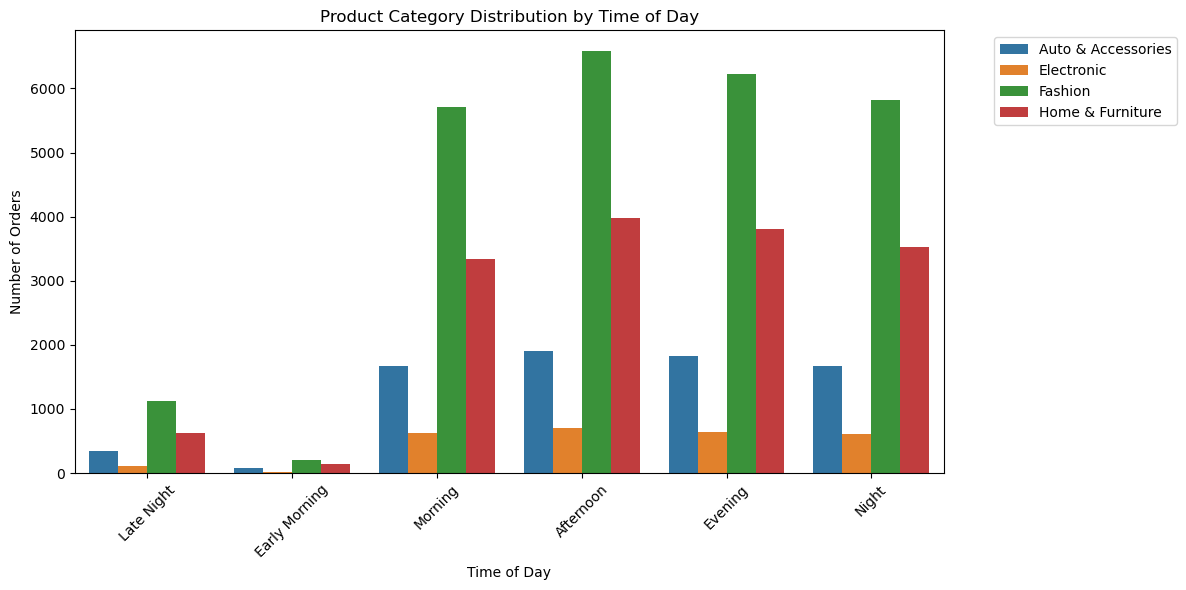

In [28]:

time_product_df = (
    df
    .groupby(['Time_of_Day', 'Product_Category'])
    .size()
    .reset_index(name='Order_Count')
)

# Define custom ordering for time-of-day segments
time_order = ["Late Night", "Early Morning", "Morning", "Afternoon", "Evening", "Night"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=time_product_df,
    x="Time_of_Day",
    y="Order_Count",
    hue="Product_Category",
    order=time_order
)
plt.title("Product Category Distribution by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [29]:
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')

In [30]:
# Snippet: Extract order hour and create membership flag (1=Member, 0=Guest)
df['Order_Hour'] = df['OrderTimestamp'].dt.hour
df['is_member'] = (df['Customer_Login_type'].str.lower() == 'member').astype(int)


In [31]:
print(df.columns)
df.head()

Index(['OrderTimestamp', 'Aging', 'Customer_Id', 'Gender', 'Device_Type',
       'Customer_Login_type', 'Product_Category', 'Product', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping_Cost', 'Order_Priority',
       'Payment_method', 'Order_Day', 'Order_Hour', 'Time_of_Day',
       'is_member'],
      dtype='object')


,OrderTimestamp,Aging,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Payment_method,Order_Day,Order_Hour,Time_of_Day,is_member
0,2018-01-02 10:56:33,8.0,37077,Female,Web,Member,Auto & Accessories,Car Media Players,140.0,1.0,0.3,46.0,4.6,Medium,credit_card,Tuesday,10,Morning,1
1,2018-07-24 20:41:37,2.0,59173,Female,Web,Member,Auto & Accessories,Car Speakers,211.0,1.0,0.3,112.0,11.2,Medium,credit_card,Tuesday,20,Night,1
2,2018-11-08 08:38:49,8.0,41066,Female,Web,Member,Auto & Accessories,Car Body Covers,117.0,5.0,0.1,31.2,3.1,Critical,credit_card,Thursday,8,Morning,1
3,2018-04-18 19:28:06,7.0,50741,Female,Web,Member,Auto & Accessories,Car & Bike Care,118.0,1.0,0.3,26.2,2.6,High,credit_card,Wednesday,19,Evening,1
4,2018-08-13 21:18:39,9.0,53639,Female,Web,Member,Auto & Accessories,Tyre,250.0,1.0,0.3,160.0,16.0,Critical,credit_card,Monday,21,Night,1


In [32]:
df['is_member'] = (df['Customer_Login_type'].str.lower() == 'member').astype(int)


In [33]:
df = pd.get_dummies(df, columns=['Gender', 'Device_Type', 'Payment_method'])


In [34]:
df.columns

Index(['OrderTimestamp', 'Aging', 'Customer_Id', 'Customer_Login_type',
       'Product_Category', 'Product', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping_Cost', 'Order_Priority', 'Order_Day', 'Order_Hour',
       'Time_of_Day', 'is_member', 'Gender_Female', 'Gender_Male',
       'Device_Type_Mobile', 'Device_Type_Web', 'Payment_method_credit_card',
       'Payment_method_debit_card', 'Payment_method_e_wallet',
       'Payment_method_money_order', 'Payment_method_not_defined'],
      dtype='object')

In [35]:
import sys
!{sys.executable} -m pip install "dask[complete]" --quiet

In [45]:


ddf = dd.read_csv(datapath, parse_dates=[['Order_Date', 'Time']])

ddf = ddf.rename(columns={'Order_Date_Time': 'OrderTimestamp'})


In [46]:
ddf = ddf.rename(columns={'Order_Date_Time': 'OrderTimestamp'})

print("Columns available:", ddf.columns.tolist())

cols = [c.lower() for c in ddf.columns]
login_col  = ddf.columns[cols.index(next(c for c in cols if 'login' in c))]
device_col = ddf.columns[cols.index(next(c for c in cols if 'device' in c))]

print(f"Using login column: {login_col}")
print(f"Using device column: {device_col}")

ddf['is_member']    = (ddf[login_col].str.lower() == 'member').astype(int)
ddf['mobile_flag']  = (ddf[device_col].str.lower() == 'mobile').astype(int)


snapshot = pd.to_datetime('2018-12-31')

agg = ddf.groupby('Customer_Id').agg({
    'OrderTimestamp': ['min', 'max', 'count'],
    'Sales':          'sum',
    'Discount':       'mean',
    'is_member':      'max',   
    'mobile_flag':    'mean'    
}).compute()


agg.columns = [
    'first_purchase','last_purchase','frequency','monetary','avg_discount',
    'is_member','mobile_ratio'
]

agg['recency'] = (snapshot - agg['last_purchase']).dt.days
agg['tenure']  = (snapshot - agg['first_purchase']).dt.days

customer_df = agg.reset_index()

print("Dask-computed customer_df shape:", customer_df.shape)
display(customer_df.head())


Columns available: ['OrderTimestamp', 'Aging', 'Customer_Id', 'Gender', 'Device_Type', 'Customer_Login_type', 'Product_Category', 'Product', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping_Cost', 'Order_Priority', 'Payment_method']
Using login column: Customer_Login_type
Using device column: Device_Type
Dask-computed customer_df shape: (38997, 10)


,Customer_Id,first_purchase,last_purchase,frequency,monetary,avg_discount,is_member,mobile_ratio,recency,tenure
0,37077,2018-01-02 10:56:33,2018-01-02 10:56:33,1,140.0,0.3,1,0.0,362,362
1,59173,2018-07-24 20:41:37,2018-07-24 20:41:37,1,211.0,0.3,1,0.0,159,159
2,41066,2018-11-08 08:38:49,2018-11-08 08:38:49,1,117.0,0.1,1,0.0,52,52
3,50741,2018-04-18 19:28:06,2018-04-18 19:28:06,1,118.0,0.3,1,0.0,256,256
4,53639,2018-08-13 21:18:39,2018-08-13 21:18:39,1,250.0,0.3,1,0.0,139,139


In [47]:

print("Columns available:", ddf.columns.tolist())


cols = [c.lower() for c in ddf.columns]
login_col  = ddf.columns[cols.index(next(c for c in cols if 'login' in c))]
device_col = ddf.columns[cols.index(next(c for c in cols if 'device' in c))]

print(f"Using login column: {login_col}")
print(f"Using device column: {device_col}")

ddf['is_member']    = (ddf[login_col].str.lower() == 'member').astype(int)
ddf['mobile_flag']  = (ddf[device_col].str.lower() == 'mobile').astype(int)

snapshot = pd.to_datetime('2018-12-31')

agg = ddf.groupby('Customer_Id').agg({
    'OrderTimestamp': ['min','max','count'],
    'Sales':          'sum',
    'Discount':       'mean',
    'is_member':      'max',   
    'mobile_flag':    'mean'   
}).compute()


agg.columns = [
    'first_purchase','last_purchase','frequency','monetary','avg_discount',
    'is_member','mobile_ratio'
]


agg['recency'] = (snapshot - agg['last_purchase']).dt.days
agg['tenure']  = (snapshot - agg['first_purchase']).dt.days


customer_df = agg.reset_index()

print("Dask-computed customer_df shape:", customer_df.shape)
display(customer_df.head())


Columns available: ['OrderTimestamp', 'Aging', 'Customer_Id', 'Gender', 'Device_Type', 'Customer_Login_type', 'Product_Category', 'Product', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping_Cost', 'Order_Priority', 'Payment_method', 'is_member', 'mobile_flag']
Using login column: Customer_Login_type
Using device column: Device_Type
Dask-computed customer_df shape: (38997, 10)


,Customer_Id,first_purchase,last_purchase,frequency,monetary,avg_discount,is_member,mobile_ratio,recency,tenure
0,37077,2018-01-02 10:56:33,2018-01-02 10:56:33,1,140.0,0.3,1,0.0,362,362
1,59173,2018-07-24 20:41:37,2018-07-24 20:41:37,1,211.0,0.3,1,0.0,159,159
2,41066,2018-11-08 08:38:49,2018-11-08 08:38:49,1,117.0,0.1,1,0.0,52,52
3,50741,2018-04-18 19:28:06,2018-04-18 19:28:06,1,118.0,0.3,1,0.0,256,256
4,53639,2018-08-13 21:18:39,2018-08-13 21:18:39,1,250.0,0.3,1,0.0,139,139


In [48]:

def compute_rfm(customer_df):
    """
    Assign Recency, Frequency, and Monetary scores based on quintile thresholds,
    then compute a composite RFM score and a weighted CLV heuristic.
    """
   
    quantiles = customer_df[['recency', 'frequency', 'monetary']] \
        .quantile([0.2, 0.4, 0.6, 0.8]) \
        .to_dict()

    def r_score(recency):
      
        if recency <= quantiles['recency'][0.2]:
            return 5
        elif recency <= quantiles['recency'][0.4]:
            return 4
        elif recency <= quantiles['recency'][0.6]:
            return 3
        elif recency <= quantiles['recency'][0.8]:
            return 2
        return 1

    def fm_score(value, col):
      
        if value <= quantiles[col][0.2]:
            return 1
        elif value <= quantiles[col][0.4]:
            return 2
        elif value <= quantiles[col][0.6]:
            return 3
        elif value <= quantiles[col][0.8]:
            return 4
        return 5

    # Compute individual R, F, M scores
    customer_df['R'] = customer_df['recency'].apply(r_score)
    customer_df['F'] = customer_df['frequency'].apply(lambda x: fm_score(x, 'frequency'))
    customer_df['M'] = customer_df['monetary'].apply(lambda x: fm_score(x, 'monetary'))

    # Composite RFM score and weighted CLV heuristic
    customer_df['RFM_Score'] = (
        customer_df['R'].astype(str) +
        customer_df['F'].astype(str) +
        customer_df['M'].astype(str)
    )
    customer_df['CLV_heuristic'] = (
        0.5 * customer_df['R'] +
        customer_df['F'] +
        customer_df['M']
    )

    return customer_df


customer_df = compute_rfm(customer_df)


print("Customer RFM scores and heuristic CLV:")
print(customer_df[['Customer_Id', 'RFM_Score', 'CLV_heuristic']].head())


Customer RFM scores and heuristic CLV:
   Customer_Id RFM_Score  CLV_heuristic
0        37077       112            3.5
1        59173       313            5.5
2        41066       412            5.0
3        50741       112            3.5
4        53639       314            6.5


In [49]:

np.random.seed(42)
customer_df['future_sales'] = customer_df['monetary'] * np.random.uniform(0.8, 1.2, size=len(customer_df))


In [50]:

features_clv = ['recency', 'frequency', 'monetary', 'tenure']
if 'avg_discount' in customer_df.columns:
    features_clv.append('avg_discount')

X_clv = customer_df[features_clv]
y_clv = customer_df['future_sales']


In [51]:

X_train, X_val, y_train, y_val = train_test_split(
    X_clv,
    y_clv,
    test_size=0.3,
    random_state=42
)


In [52]:

clv_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42
)
clv_model.fit(X_train, y_train)

y_pred = clv_model.predict(X_val)
mse  = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_val, y_pred)

print("CLV Model Performance on Validation Set:")
print(f"  • MSE:  {mse:.2f}")
print(f"  • RMSE: {rmse:.2f}")
print(f"  • R²:   {r2:.2f}")

joblib.dump(clv_model, 'clv_model.pkl')


CLV Model Performance on Validation Set:
  • MSE:  748.70
  • RMSE: 27.36
  • R²:   0.95


['clv_model.pkl']

In [53]:

cutoff_date = pd.Timestamp('2018-09-01')
label_end   = cutoff_date + timedelta(days=30)


ddf_pre  = ddf[ddf['OrderTimestamp'] <  cutoff_date]
ddf_post = ddf[(ddf['OrderTimestamp'] >= cutoff_date) & (ddf['OrderTimestamp'] < label_end)]

pre_agg = (
    ddf_pre
    .groupby('Customer_Id')
    .agg({
        'OrderTimestamp': ['min', 'max', 'count'],   
        'Sales':          'sum',                    
        'Discount':       'mean',                    
        'is_member':      'max',                    
        'mobile_flag':    'mean'                  
    })
    .compute()
)


pre_agg.columns = [
    'first_purchase', 'last_purchase', 'frequency',
    'monetary', 'avg_discount', 'is_member', 'mobile_ratio'
]
pre_agg = pre_agg.reset_index()


pre_agg['recency'] = (cutoff_date - pre_agg['last_purchase']).dt.days
pre_agg['tenure']  = (cutoff_date - pre_agg['first_purchase']).dt.days


post_counts = (
    ddf_post
    .groupby('Customer_Id')
    .size()
    .rename('orders_next_30d')
    .compute()
    .reset_index()
)
features = (
    pre_agg
    .merge(post_counts, on='Customer_Id', how='left')
    .fillna({'orders_next_30d': 0})
)
features['churn'] = (features['orders_next_30d'] == 0).astype(int)


churn_features = [
    'recency', 'frequency', 'monetary',
    'avg_discount', 'is_member', 'mobile_ratio', 'tenure'
]
X = features[churn_features]
y = features['churn']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'),           
    StandardScaler(),
    LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        random_state=42
    )
)
lr_pipe.fit(X_train, y_train)

preds = lr_pipe.predict(X_test)
print("Churn Model Performance:")
print("Accuracy:", round(accuracy_score(y_test, preds), 3))
print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=['Stay','Churn']))


Churn Model Performance:
Accuracy: 0.488

Classification Report:
              precision    recall  f1-score   support

        Stay       0.05      0.48      0.09       409
       Churn       0.94      0.49      0.64      7419

    accuracy                           0.49      7828
   macro avg       0.50      0.48      0.37      7828
weighted avg       0.90      0.49      0.61      7828



In [71]:
# 1) Random Forest
rf_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    )
)
rf_pipe.fit(X_train, y_train)
rf_preds = rf_pipe.predict(X_test)

print("=== Random Forest Classifier ===")
print("Accuracy:", round(accuracy_score(y_test, rf_preds), 3))
print(classification_report(y_test, rf_preds, target_names=['Stay','Churn']))

# 2) Histogram-based Gradient Boosting 
hgb_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    HistGradientBoostingClassifier(
        max_iter=200,
        learning_rate=0.1,
        random_state=42
    )
)
hgb_pipe.fit(X_train, y_train)
hgb_preds = hgb_pipe.predict(X_test)

print("\n=== HistGradientBoostingClassifier ===")
print("Accuracy:", round(accuracy_score(y_test, hgb_preds), 3))
#print(classification_report(y_test, hgb_preds, target_names=['Stay','Churn']))
print(classification_report(y_test, hgb_preds, target_names=["Stay", "Churn"], zero_division=0))


=== Random Forest Classifier ===
Accuracy: 0.923
              precision    recall  f1-score   support

        Stay       0.07      0.04      0.05       409
       Churn       0.95      0.97      0.96      7419

    accuracy                           0.92      7828
   macro avg       0.51      0.50      0.50      7828
weighted avg       0.90      0.92      0.91      7828


=== HistGradientBoostingClassifier ===
Accuracy: 0.948
              precision    recall  f1-score   support

        Stay       0.00      0.00      0.00       409
       Churn       0.95      1.00      0.97      7419

    accuracy                           0.95      7828
   macro avg       0.47      0.50      0.49      7828
weighted avg       0.90      0.95      0.92      7828



In [55]:
# Build pipeline: impute missing → LightGBM
lgb_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=42
    )
)


lgb_pipe.fit(X_train, y_train)

lgb_preds = lgb_pipe.predict(X_test)

print("=== LightGBM Classifier ===")
print("Accuracy:", round(accuracy_score(y_test, lgb_preds), 3))
print(classification_report(y_test, lgb_preds, target_names=['Stay','Churn']))


[LightGBM] [Info] Number of positive: 17311, number of negative: 954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 18265, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
=== LightGBM Classifier ===
Accuracy: 0.729
              precision    recall  f1-score   support

        Stay       0.06      0.29      0.10       409
       Churn       0.95      0.75      0.84      7419

    accuracy                           0.73      7828
   macro avg       0.51      0.52      0.47      7828
weighted avg       0.90      0.73      0.80      7828



In [ ]:
joblib.dump(lgb_pipe, 'churn_lgb_pipe.pkl')


In [ ]:
joblib.dump(clv_model, 'clv_model.pkl')

In [ ]:
import joblib
joblib.dump(clv_model,    "clv_model.pkl")
joblib.dump(lgb_pipe,   "churn_lgb_pipe.pkl")

In [102]:
# Prepare final data frame for Streamlit
X_clv_final = customer_df[[
    'recency', 'frequency', 'monetary', 'tenure', 'avg_discount'
]]

X_churn = customer_df[[
    'recency', 'frequency', 'monetary', 'avg_discount', 'is_member', 'mobile_ratio', 'tenure'
]]

# predictions
customer_df['Churn_Prob'] = lgb_pipe.predict_proba(X_churn)[:, 1]
customer_df['Predicted_CLV'] = clv_model.predict(X_clv_final)
customer_df['ExpectedLoss'] = customer_df['Churn_Prob'] * customer_df['Predicted_CLV']

# Action based on threshold
threshold_loss = customer_df['ExpectedLoss'].median()
customer_df['Action'] = np.where(customer_df['ExpectedLoss'] >= threshold_loss, 'Retain', 'Ignore')

# Final output
final_output = customer_df[[
    'Customer_Id', 'Churn_Prob', 'Predicted_CLV', 'ExpectedLoss', 'Action'
]]

final_output.to_csv("final_output.csv", index=False)
print("final_output.csv written to disk")


final_output.csv written to disk
